# Introduction

For this second milestone in the project, we're going to perform the following preliminary tasks to evaluate the feasibility of our project:
- [x] Load and pre-process the data
- [x] Exploratory data analysis to confirm intuitive correlations between variables and define a potential main article
- [x] Define a primitive set of clichés, a performance metric and verify if the passing paths using clichés have better performance
- [x] Study a particular cliché and the categorization of the articles linked to it and our main article

In the code below, we'll mainly be using the graph data from the Wikispeedia dataset. 
In particular, we use the finished paths, a little bit the unfinished paths, the adjacency matrix and theoretical shortest paths.


# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from preprocessing import *
from data_quantity_analysis import *
from cliches import *
from plot_helpers import *

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#if the data has not been downloaded yet
if not os.path.exists('data'):
    %run download_data.py

# Preprocessing

In [4]:
(
    articles,
    categories,
    links,
    paths_finished,
    paths_unfinished,
) = import_and_clean_data()

# Data quantity analysis - exploratory data analysis

## General 

We start by exploring the data set to get an overview of the data and the information it provides. As a first step, we're trying to create graphs that could potentially give us information about how players play and think.

As the aim of our project is to look at the role of clichés in the choice of artworks by users and, more generally, the role they play in information, we begin by looking at the sub-sets of data that contain the most information.

Here we look at the 100 most visited articles by players and then the 100 most used targets, both among the finished paths.

[('<', 16009), ('United_States', 8654), ('Europe', 4270), ('United_Kingdom', 3806), ('England', 3260), ('Earth', 3152), ('Africa', 2742), ('World_War_II', 2256), ('North_America', 1829), ('Germany', 1737), ('Animal', 1642), ('France', 1570), ('Human', 1554), ('Mammal', 1548), ('Computer', 1513), ('Science', 1453), ('Periodic_table', 1396), ('English_language', 1392), ('Brain', 1301), ('Atlantic_Ocean', 1266), ('Telephone', 1239), ('India', 1210), ('Viking', 1193), ('Bird', 1183), ('Asia', 1164), ('Asteroid', 1164), ('Agriculture', 1111), ('Plant', 1105), ('China', 1104), ('Christianity', 1052), ('Japan', 1051), ('United_Nations', 1039), ('Zebra', 1029), ('Theatre', 1027), ('Internet', 1001), ('Russia', 995), ('Australia', 980), ('Chemistry', 973), ('London', 938), ('Sun', 914), ('Canada', 897), ('South_America', 891), ('European_Union', 877), ('Adolf_Hitler', 872), ('Water', 868), ('Solar_System', 857), ('President_of_the_United_States', 833), ('Italy', 832), ('Physics', 829), ('Chemic

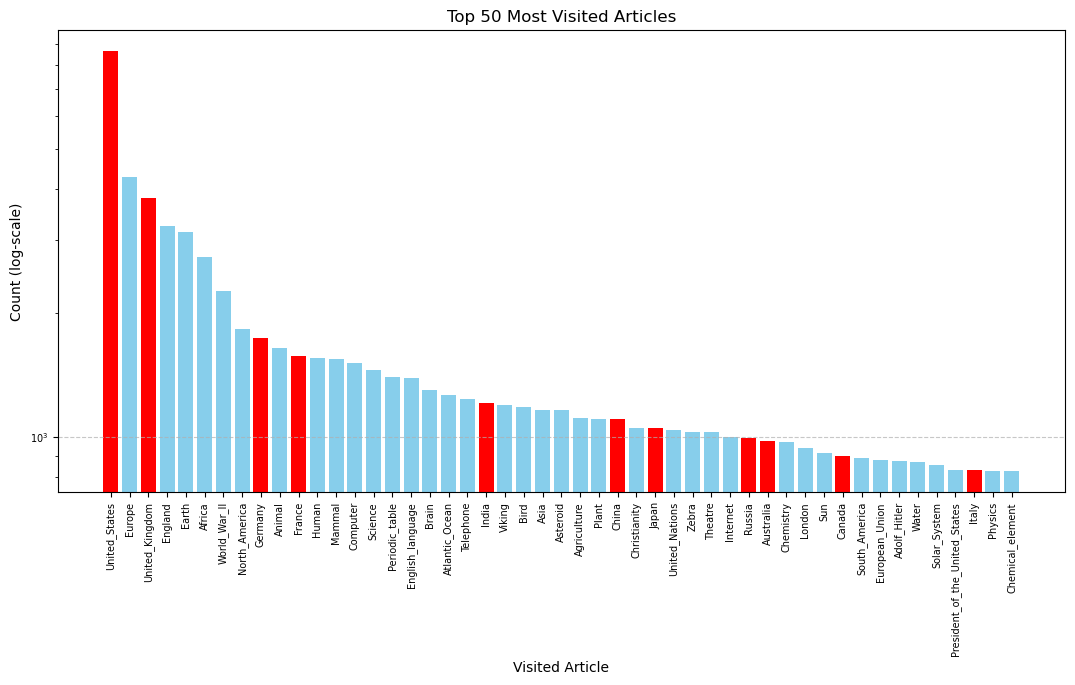

In [7]:
top_50_visited_articles(paths_finished, categories, show=True)

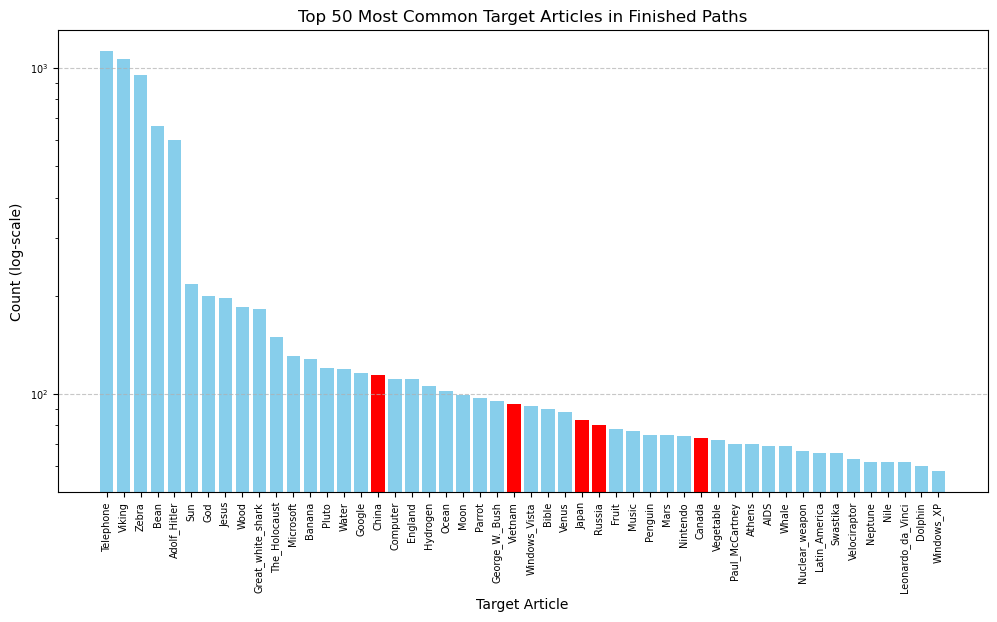

In [8]:
top_50_target_articles(paths_finished, categories, show=True)

We then look at the distribution of the length and duration of the finished paths to see if these correspond to a normal trend or if there are particular features to be analysed.

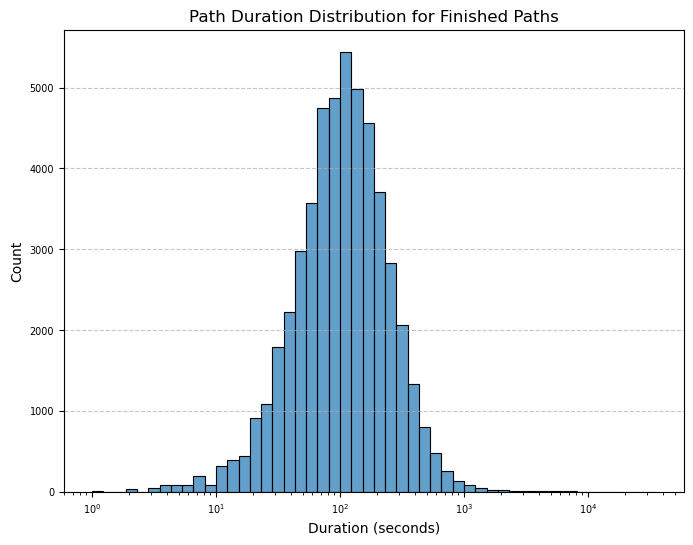

In [7]:
path_duration_distribution(paths_finished, show=True)

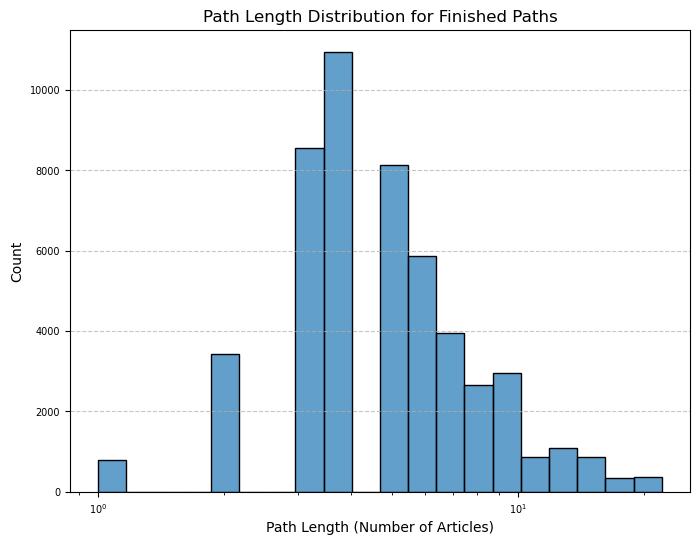

In [8]:
path_length_distribution(paths_finished, show=True)

Now that we've looked at distributions with a single valuer, we'll look at the links between several valuers: in particular, we'll look at the interaction between the length of the path and the length of the game's duration, and then the interaction between the score given to the chmin and its length.

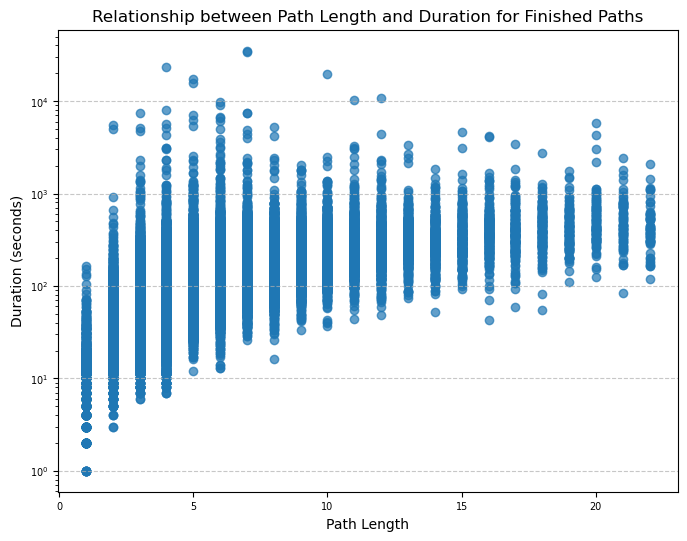

In [9]:
path_length_vs_duration(paths_finished, show=True)

<Figure size 1000x900 with 0 Axes>

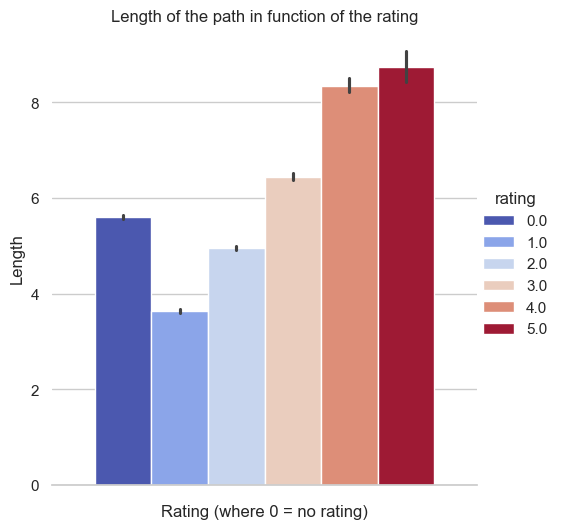

In [10]:
rating_vs_path_length(paths_finished, show=True)

Based on the previous two plots, we could hypothesize that the length of the path is correlated to the duration of the game and its rating, simply based on the apparent monotonicity of the data.
Both these interpretations are intuitive but we should perform a statistical regressions and tests to confirm them.

We may be interested in another more objective metrics. In other word, we try to compare how the difference between the actual path taken and the shortest (theoretical) path behaves with respect to the rating given.

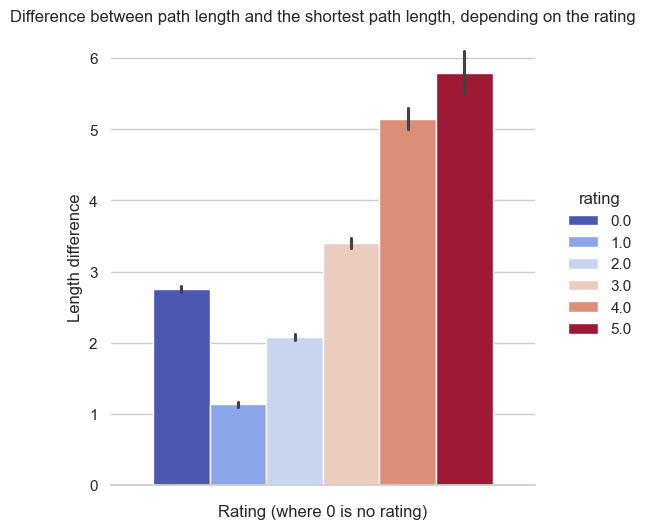

In [11]:
ax = sns.catplot(
    data=paths_finished,
    y="diff_length",
    kind="bar",
    palette="coolwarm",
    hue="rating",
)
ax.despine(left=True)
plt.title("Difference between path length and the shortest path length, depending on the rating")
plt.xlabel("Rating (where 0 is no rating)")
plt.ylabel("Length difference")
plt.show()

Again, there seems to be some difference between the difference of length of paths for different ratings. Notice that compared to the path lengths for different rating, the difference between rating 4 vs 5 in more siginificant in the plot of difference in length. Indeed, the error bars do not overlap in these ratings.

For this reason, we will choose this difference between the path length and the shortest path length as our performance metric.

## Specific example: the United Kingdom

Now that we've looked at the data as a whole, let's take a closer look at one data set in particular, that of United Kingdom. This will allow us to define a set of snapshots for this particular area. We've decided to use United Kingdom as an example because it's one of the most visited items in the dataset and as one of our european neighbors, we can easily find clichés that are true.

In [12]:
main_article = "United_Kingdom"

In [13]:
count_in_out_neighbors(paths_finished, paths_unfinished, main_article)

Number of paths finished that contain United Kingdom: 3732
Number of paths unfinished that contain UnitedKingdom 1354
Number of paths that finished with United Kingdom: 28


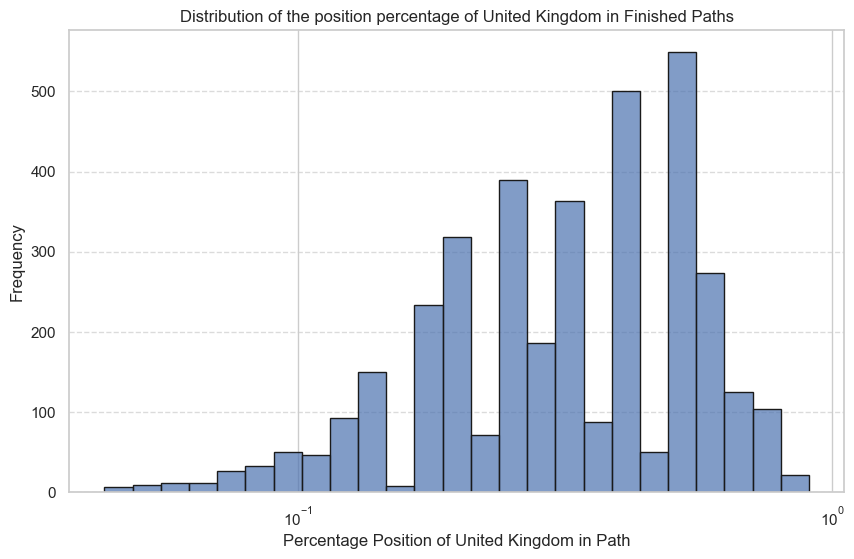

In [14]:
distribution_position_percentage(paths_finished, main_article, show=True)

In generality, we can't really infer any particular distribution from the data. However, in future analysis we could try to fit distributions when we consider the position of the main article conditonally on additional events (e.g. the path also contains a particular cliché).

In [15]:
# define main_article for analysis: 
main_article = "United_Kingdom"

# only keep rows such that main_article in path
around_main_article = get_df_main_article(paths_finished, main_article=main_article).copy(deep=True)

# get category of the main_article
around_main_article["main_article_category"] = around_main_article["path"].apply(lambda path: get_category_main_article(main_article, path, categories))

# article juste before/just after main_article
# TODO: function to be improved/discussed. What do we want to do with "<"?
around_main_article["around_path"] = around_main_article["path"].apply(
    lambda path: get_index_main_article_in(main_article, path)
)

# update initial/target_article, initial/target_category
around_main_article["around_IA"] = around_main_article["around_path"].apply(
    lambda path: path[0]
)
around_main_article["around_TA"] = around_main_article["around_path"].apply(
    lambda path: path[-1]
)
around_main_article["around_IC"] = around_main_article["around_IA"].apply(
    lambda article: categories[categories["article"] == article]["category1"].values
)
around_main_article["around_TC"] = around_main_article["around_TA"].apply(
    lambda article: categories[categories["article"] == article]["category1"].values
)

around_main_article

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,shortest_path,diff_length,target_article,main_article_category,around_path,around_IA,around_TA,around_IC,around_TC
74,565e6dc60eeca66c,1253358736,77,"[Aberdeen, City_status_in_the_United_Kingdom, ...",0.0,5,3,2,Bread,[Geography],"[Aberdeen, City_status_in_the_United_Kingdom, ...",Aberdeen,Market,[Geography],[Business_Studies]
113,4dc8af51482ebb5a,1336876538,221,"[Achilles, Ethiopia, United_Kingdom, World_War...",3.0,4,2,2,Winston_Churchill,"[Countries, Geography, Geography]","[Ethiopia, United_Kingdom, World_War_II]",Ethiopia,World_War_II,"[Geography, Countries]",[History]
115,0adc390d00c8c538,1344743190,63,"[Achilles, Greek_mythology, Ancient_Greece, Eu...",3.0,6,2,4,Winston_Churchill,"[Countries, Geography, Geography]","[Europe, United_Kingdom, Prime_Minister_of_the...",Europe,Prime_Minister_of_the_United_Kingdom,[Geography],[Citizenship]
117,31980f901eee5467,1346717015,117,"[Achilles, Ethiopia, United_Kingdom, World_War...",0.0,4,2,2,Winston_Churchill,"[Countries, Geography, Geography]","[Ethiopia, United_Kingdom, World_War_II]",Ethiopia,World_War_II,"[Geography, Countries]",[History]
121,3a11233c52f824f8,1350896212,224,"[Achilles, William_Shakespeare, England, Great...",0.0,7,2,5,Winston_Churchill,"[Countries, Geography, Geography]","[<, United_Kingdom, World_War_II]",<,World_War_II,[],[History]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51280,6f4978c43a8faffd,1358871308,164,"[Timken_1111, Chicago, Roman_Catholic_Church, ...",0.0,5,4,1,British_monarchy,"[History, People]","[Industrial_Revolution, George_III_of_the_Unit...",Industrial_Revolution,British_monarchy,[History],[Citizenship]
51287,4e3201ac6a75f14f,1324457682,150,"[Tropical_Storm_Larry_(2003), Pacific_Ocean, U...",3.0,8,3,5,Magna_Carta,"[Countries, Geography, Geography]","[Pacific_Ocean, United_Kingdom, England]",Pacific_Ocean,England,[Geography],[Geography]
51299,3cc4f2837bf22048,1325177555,59,"[Union_Station_(San_Diego), World_War_II, Unit...",0.0,4,2,2,Bristol,"[Countries, Geography, Geography]","[World_War_II, United_Kingdom, England]",World_War_II,England,[History],[Geography]
51301,3278e904185ec5bc,1361584612,168,"[Valparaíso, World_Heritage_Site, Europe, <, U...",0.0,10,3,7,Hellenistic_Greece,"[Countries, Geography, Geography]","[<, United_Kingdom, United_Nations]",<,United_Nations,[],[Citizenship]


/Users/tudoroancea/Desktop/epfl/ma3/cs-401/ada-2023-project-abracadabra2023/plot_helpers.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


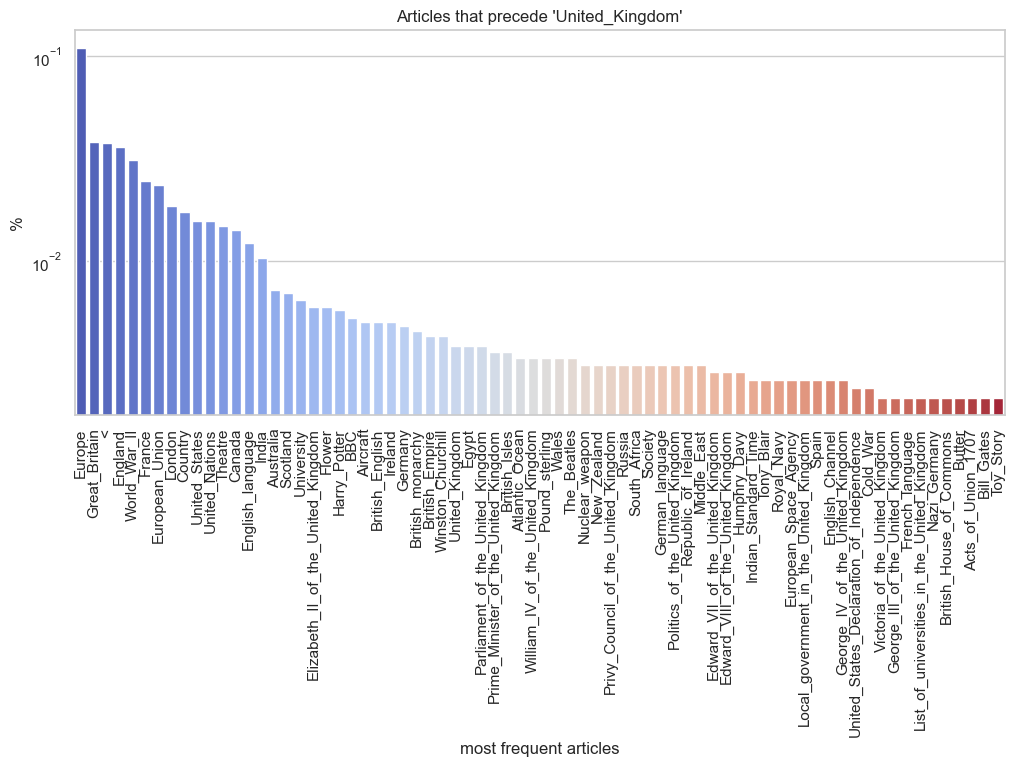

In [16]:
# keep only 10% most frequent articles just after main_article
most_frequent_before = around_main_article["around_IA"].value_counts(normalize=True)
plot_most_frequent_articles(most_frequent_before, "precede");

/Users/tudoroancea/Desktop/epfl/ma3/cs-401/ada-2023-project-abracadabra2023/plot_helpers.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


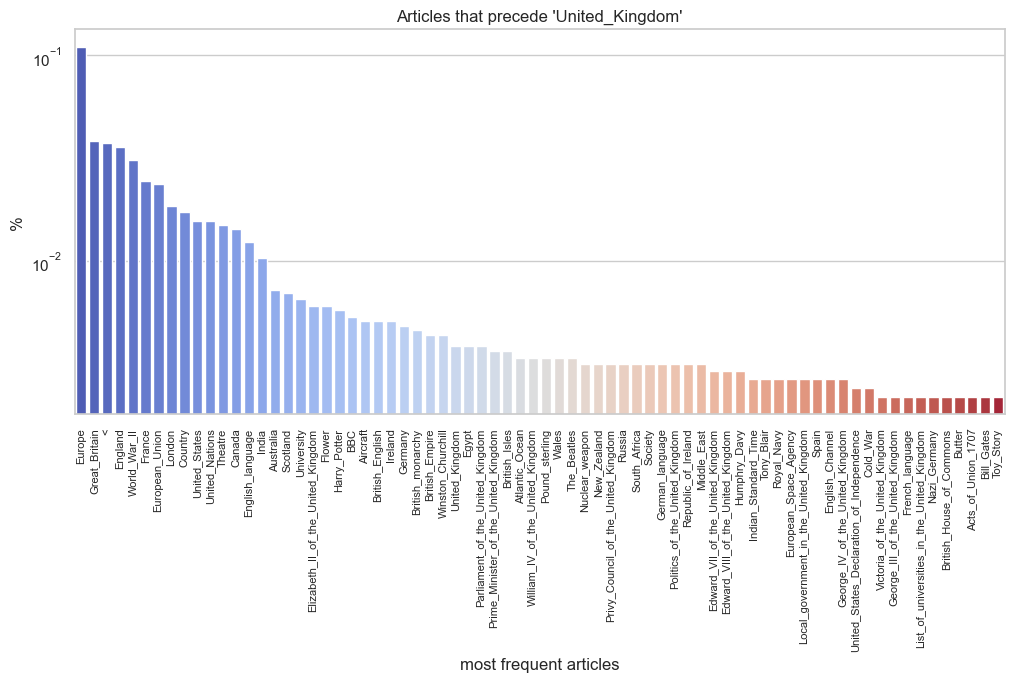

In [17]:
# keep only 10% most frequent articles just after main_article
most_frequent_before = around_main_article["around_IA"].value_counts(normalize=True)
plot_most_frequent_articles(most_frequent_before, "precede");

# Define our cliches 

## Cliches preprocessing

In this section we will define and extract data from the clichés. This will enable us to carry out analyses to discover whether or not there are any links between our chosen subject and the clichés.

## Statistical tests for difference of path length for different cliches

Now, we want to find some statistical evidence of whether clichés influence the length of the path from the initial article to the target article. From the previous exploration, it seems that the difference of path length between the actual path taken and the shortest (theoretical) path is a "good" metric of the player's performance.

So the idea is to select all the rows in `paths_finished` that contain the main article `United_Kingdom`. The selection of clichés remains to be done in an unbiased way. For now, we select "cliché" articles from the plots just above (see selected cliché articles below)[^1]. Next, it makes sense to compare difference in length for a given rating. Otherwise, as stated earlier, "harder" articles seem to tend to have higher difference in length and hence we would be comparing different categories.

To check whether there is a statistical difference, we compute a Welch's t-test. Indeed, given a rating, we assume that our observations are independant. Additionally, it seems that the difference in length among a rating between those who went through cliché articles and those who did not do not have same variance. 

[^1]: We are looking into different ways to retrieve cliché articles.

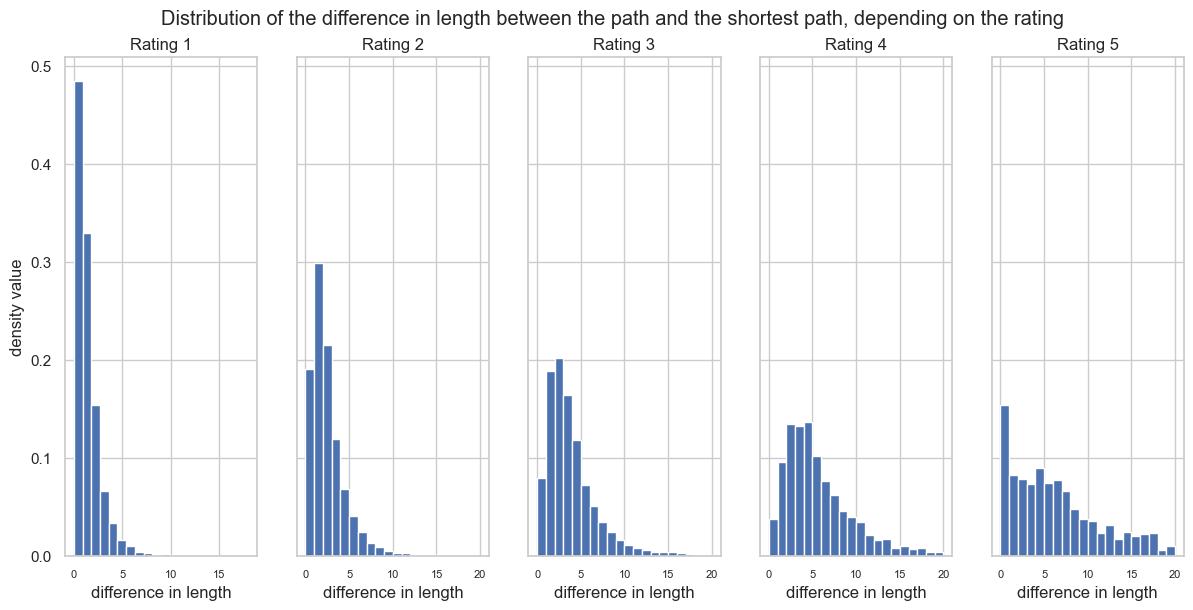

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(12, 6), sharey=True)
fig.tight_layout()

for i, ax in enumerate(axes):
    temp = paths_finished[paths_finished["rating"] == i + 1]["diff_length"]
    ax.hist(temp, bins=20, density=True)
    ax.set_xlabel("difference in length")
    if i == 0:
        ax.set_ylabel("density value")
    ax.set_title(f"Rating {i+1}")

# make room for suptitle
fig.subplots_adjust(top=0.9)
fig.suptitle(
    "Distribution of the difference in length between the path and the shortest path, depending on the rating"
)

plt.show()

We observe that the higher the rating, the higher the variance. Additionally, it is worth noting that the data is imbalanced among the ratings.

Above, we have compared the variance between different ratings but not among a rating between the paths that go through cliché articles and those that do not. 

In [19]:
# select some cliches
main_article_cliches = [
    "William_Shakespeare",
    "Harry_Potter",
    "BBC",
    "Winston_Churchill",
    "The_Beatles",
    "Elizabeth_II_of_the_United_Kingdom",
    "Flower",
    "British_monarchy",
    "British_Empire",
    "Prime_Minister_of_the_United_Kingdom",
    "Pound_sterling",
    "London",
]

ratings = np.arange(1, 6, dtype=int)

In [20]:
from cliches import test_difference_path_length_cliche

# create dataframe
test_cliche = pd.DataFrame(
    columns=[
        "main_article",
        "cliche",
        "rating",
        "mean_cliche",
        "mean_nocliche",
        "shape_cliche",
        "shape_nocliche",
        "statistic",
        "p_value",
    ]
)

# test different ratings and cliches
for rating in ratings:
    for cliche in main_article_cliches:
        (
            stat,
            p,
            mean_path_cliche,
            mean_path_nocliche,
            shape_cliche,
            shape_nocliche,
        ) = test_difference_path_length_cliche(
            paths_finished, rating, cliche, main_article, False, False
        )
        test_cliche.loc[test_cliche.shape[0]] = [
            main_article,
            cliche,
            rating,
            mean_path_cliche,
            mean_path_nocliche,
            shape_cliche,
            shape_nocliche,
            stat,
            p,
        ]

test_cliche

/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,main_article,cliche,rating,mean_cliche,mean_nocliche,shape_cliche,shape_nocliche,statistic,p_value
0,United_Kingdom,William_Shakespeare,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
1,United_Kingdom,Harry_Potter,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
2,United_Kingdom,BBC,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
3,United_Kingdom,Winston_Churchill,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
4,United_Kingdom,The_Beatles,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
5,United_Kingdom,Elizabeth_II_of_the_United_Kingdom,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
6,United_Kingdom,Flower,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
7,United_Kingdom,British_monarchy,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
8,United_Kingdom,British_Empire,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
9,United_Kingdom,Prime_Minister_of_the_United_Kingdom,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN


Note that in most cases, we do not have enough data to compare. However, those going through the article `London` are *almost* statistically significantly (at $\alpha=0.05$) more performant that others fore rating 1 and 2.

# Categories and clichés

We consider here the finished paths passing through our chosen main article "United_Kingdom".
We enumerate all the categories of the articles at most 3 steps away from the main article on these paths and construct a bar chart to visualize their number of occurences.
We further color each category bar depending on whether "United_Kingdom" belongs to it or not.
Finally, arrows are used to indicate specific categories of a given cliché (here “William_Shakespeare”, drawn from the list created in the previous section). 

In [21]:
all_categories, subcategories1, subcategories2, subcatgeories3 = separate_categories(main_article, categories)

Non-coincide Categories at 1 step away from UK: [('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900'), ('United_Kingdom', 'Citizenship'), ('United_Kingdom', 'Politics_and_government'), ('United_Kingdom', 'African_Geography'), ('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History')]
Non-coincide Categories at 2 steps away from UK: [('United_Kingdom', 'Ancient_History_Classical_History_and_Mythology'), ('United_Kingdom', 'African_Geography'), ('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900')]
Non-coincide Categories at 3 steps away from UK: [('United_Kingdom', 'Ancient_History_Classical_History_and_Mythology'), ('United_Kingdom', 'African_Geogra

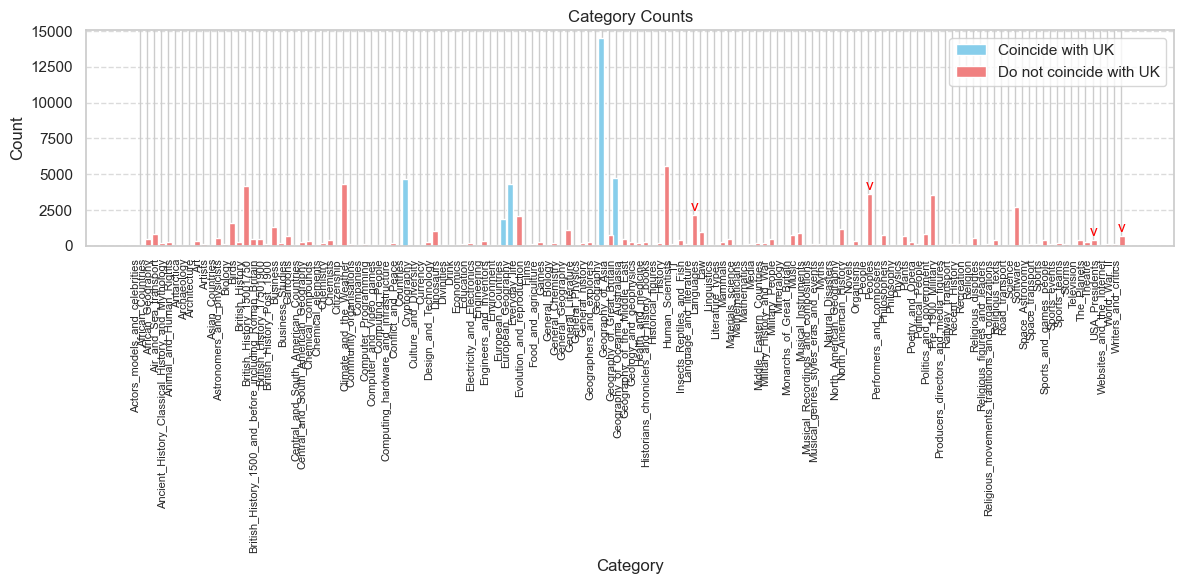

In [22]:
combine_results(paths_finished, main_article, categories, all_categories, ["category1", "category2", "category3"])

This bar plot shows that:
- the categories that "United_Kingdom" belongs to are (among) the most frequent ones, which is not surprising given that the hyperlinks in an article should redirect to related articles, and given that the players often rely on semantic links to find the target article.
- if we look at the categories of our designated cliché "William_Shakespeare", they are quite frequent, although not coinciding with the "United_Kingdom"'s catgeories. This is not surprising either, because of the very nature of the two articles: one of them is a country, the other one is a playwright. However, we can see that the categories of "William_Shakespeare" are quite frequent, which is a good sign for our project.

# Data augmentation pipeline

As seen previously, we do not have much data to extract meaningful results. So, we may want to augment our data.

The pipeline for augmenting our data is the following: we analyze the clichés around the UK in the SeeGull data set as well as the content of the articles and try to link them together. More precisely, we retreive the "topics" of the clichés from the SeeGull data set (eg alcohol, liquid etc.) and do the same for each articles.

So far, we have two sets of topics: one from the SeeGull dataset, and one for each article from the main data base. We add article to our list of cliché articles if there are "enough" topics in common.

The main part of this analysis is to make sure that is pipeline is sensible:
- does is make sense to compare the two sets of topics? 
- does it actually augmente the data (statistical significance for the t-tests above)

In [2]:
import spacy
from empath import Empath
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, PlaintextCorpusReader
from nltk.stem import WordNetLemmatizer
import nltk

# download if first time running library
download = False

if download:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

DATA_PATH = "data/"
path_articles = DATA_PATH + "articles_plain_text/"

## SeeGull topics

In [3]:
from cliches import top_k_categories, get_topics

In [4]:
# import SeeGull dataset
df_cliches = pd.read_csv("data/stereotypes_global_v2.csv")

# example of use of top_k_categories
# all UK countries
df_uk = df_cliches[
    np.isin(df_cliches["identity"], ["British", "Irish", "Scottish", "Welsh"])
]

attributes_uk = " ".join(df_uk["attribute"].to_numpy())

topics_seegull = top_k_categories(attributes_uk, 10, True)

alcohol              8.383%
liquid               7.784%
dominant_personality 5.389%
party                5.389%
negative_emotion     4.790%
love                 4.192%
wealthy              3.593%
eating               3.593%
optimism             2.994%
independence         2.994%


## Wikispeedia dataset topics

In [7]:
# get the topics of the articles and write them in a dataframe

# get all articles (corpus)
# only analyzing lim articles, do for all at term
all_articles = PlaintextCorpusReader(
    path_articles, ".*.txt", encoding="utf8"
).fileids()

# get their topics and store in dataframe
df_topics = pd.DataFrame(columns=["article_name", "topics", "confidence"])

# number of topics to keep
n = 10
for article_name in all_articles:
    topics_value = pd.DataFrame(
        get_topics(article_name, data_path=path_articles), columns=["topics", "value"]
    )

    new_row = {
        "article_name": article_name,
        "topics": topics_value["topics"].to_numpy()[:n],
        "confidence": topics_value["value"].to_numpy()[:n],
    }

    df_topics.loc[df_topics.shape[0]] = new_row

In [8]:
# write to csv
import csv

topics_file = DATA_PATH + "topics_articles.csv"

# if os.path.isfile(topics_file):
#     with open(topics_file, "a", newline="") as csvfile:
#         csvwriter = csv.writer(csvfile)

#         csvwriter.writerows(df_topics.to_numpy())
# else:
#     df_topics.to_csv(
#         topics_file,
#         sep=",",
#         encoding="utf-8",
#         columns=["article_name", "topics", "confidence"],
#         header=True,
#         index=False,
#     )

def write_to_csv(data_path_article, df, columns, header=True, index=False):
    if os.path.isfile(data_path_article):
        with open(data_path_article, "a") as csvfile:
            csvwriter = csv.writer(csvfile)

            csvwriter.writerows(df.to_numpy())
    else:
        df.to_csv(
            data_path_article,
            sep=",",
            encoding="utf-8",
            columns=columns,
            header=header,
            index=index,
        )

In [9]:
# import written dataset (sanity check)
if os.path.exists(topics_file):
    topics = pd.read_csv(topics_file, sep=",")
    display(topics)
else:
    print("file does not exists")

,article_name,topics,confidence
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in.txt,['wedding' 'family' 'royalty' 'medieval' 'deat...,[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
1,%C3%85land.txt,['beach' 'water' 'exotic' 'sailing' 'ocean' 'h...,[0.2 0.2 0.2 0.2 0.2 0. 0. 0. 0. 0. ]
2,%C3%89douard_Manet.txt,['art' 'appearance' 'fashion' 'beauty' 'femini...,[0.2 0.2 0.2 0.2 0.2 0.2 0. 0. 0. 0. ]
3,%C3%89ire.txt,['government' 'help' 'office' 'dance' 'money' ...,[0.2 0. 0. 0. 0. 0. 0. 0. 0. 0. ]
4,%C3%93engus_I_of_the_Picts.txt,['wedding' 'family' 'royalty' 'medieval' 'deat...,[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0. 0. ]
...,...,...,...
4599,Zionism.txt,['help' 'office' 'dance' 'money' 'wedding' 'do...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4600,Zirconium.txt,['tool' 'breaking' 'help' 'office' 'dance' 'mo...,[0.2 0.2 0. 0. 0. 0. 0. 0. 0. 0. ]
4601,Zoroaster.txt,['celebration' 'ancient' 'meeting' 'party' 'he...,[0.2 0.2 0.2 0.2 0. 0. 0. 0. 0. 0. ]
4602,Zuid-Gelders.txt,['speaking' 'hearing' 'shape_and_size' 'help' ...,[0.4 0.2 0.2 0. 0. 0. 0. 0. 0. 0. ]


### Articles' content with proper noun
(pushed from Anna's work)

The idea is to look at the content of the articles and compare it to the reference article.

#### First attempt
First attempt takes the content in general without any filtering.

In [ ]:
# import topics by article
topics = pd.read_csv(DATA_PATH + "topics_articles.csv")

In [ ]:
# Articles to compare
articles_to_compare_1 = ["Viking.txt", "Leonardo_da_Vinci.txt", "Venus.txt"]
articles_to_compare_2 = ["William_Shakespeare.txt", "London.txt", "BBC.txt"]

# Filter DataFrame
df_compare_1 = topics[topics['article_name'].isin(articles_to_compare_1)]
df_compare_2 = topics[topics['article_name'].isin(articles_to_compare_2)]

In [ ]:
df_compare_2[['article_name', 'topics']].to_csv(DATA_PATH + "compare_2_topics.csv", index=False)

In [ ]:
# United Kingdom topics
uk_topics_row = topics[topics['article_name'] == 'United_Kingdom.txt']

In [ ]:
uk_topics_row

In [ ]:
# Check if the United Kingdom is in the DataFrame
if not uk_topics_row.empty:
    uk_topics = uk_topics_row.iloc[0]['topics']

    # Compare topics
    def compare_topics(topics_str1, topics_str2):
        # Convert string representations to actual lists
        list1 = topics_str1.split(' ')
        list2 = topics_str2.split(' ')

        set1 = set(list1)
        set2 = set(list2)
        common_topics = set1 & set2
        return common_topics

    # Compare topics for df_compare_1
    for index, row in df_compare_1.iterrows():
        common_topics = compare_topics(row['topics'], uk_topics)
        print(f"Common topics for {row['article_name']} and United Kingdom: {common_topics}")

    # Compare topics for df_compare_2
    for index, row in df_compare_2.iterrows():
        common_topics = compare_topics(row['topics'], uk_topics)
        print(f"Common topics for {row['article_name']} and United Kingdom: {common_topics}")
else:
    print("United Kingdom not found in the DataFrame.")

Compare 10 random articles

In [ ]:
np.random.seed(16)

# Randomly select 10 articles
random_articles = topics.sample(n=10)

# United Kingdom topics
uk_topics_row = topics[topics['article_name'] == 'United_Kingdom.txt']

# Check if the United Kingdom is in the DataFrame
if not uk_topics_row.empty:
    uk_topics = uk_topics_row.iloc[0]['topics']

    # Function to compare topics
    def compare_topics(topics_str1, topics_str2):
        # Convert string representations to actual lists
        list1 = topics_str1.split(' ')
        list2 = topics_str2.split(' ')

        set1 = set(list1)
        set2 = set(list2)
        common_topics = set1 & set2
        return common_topics

    # Compare topics for the randomly selected articles
    for index, row in random_articles.iterrows():
        common_topics = compare_topics(row['topics'], uk_topics)
        print(f"Common topics for {row['article_name']} and United Kingdom: {common_topics}")

    # Save 'topics' column of random_articles to a CSV file
    random_articles[['article_name', 'topics']].to_csv(DATA_PATH + "random_articles_topics.csv", index=False)
else:
    print("United Kingdom not found in the DataFrame.")


In [ ]:
# /!\ dataset is stored in "top_50_common_topics.csv" file

# Set a random seed for reproducibility
np.random.seed(47)

# United Kingdom topics
uk_topics_row = topics[topics['article_name'] == 'United_Kingdom.txt']

# Check if the United Kingdom is in the DataFrame
if not uk_topics_row.empty:
    uk_topics = uk_topics_row.iloc[0]['topics']

    # Function to compare topics
    def compare_topics(topics_str1, topics_str2):
        # Convert string representations to actual lists
        list1 = topics_str1.split(' ')
        list2 = topics_str2.split(' ')

        set1 = set(list1)
        set2 = set(list2)
        common_topics = set1 & set2
        return common_topics

    # Compare topics for all articles in the dataset
    comparisons_with_common_topics = []

    for index, row in topics.iterrows():
        common_topics = compare_topics(row['topics'], uk_topics)
        if common_topics:
            comparisons_with_common_topics.append({'article_name': row['article_name'], 'common_topics': common_topics})

    # Sort comparisons based on the number of common topics
    comparisons_with_common_topics.sort(key=lambda x: len(x['common_topics']), reverse=True)

    # Print the top 5 comparisons
    print("Top 5 comparisons with most common topics:")
    for i in range(min(5, len(comparisons_with_common_topics))):
        print(f"{comparisons_with_common_topics[i]['article_name']} and United Kingdom: {comparisons_with_common_topics[i]['common_topics']}")

    # Save the top 50 comparisons to a CSV file
    top_50_comparisons = comparisons_with_common_topics[:50]
    if top_50_comparisons:
        df_top_50_comparisons = pd.DataFrame(top_50_comparisons)
        df_top_50_comparisons.to_csv(DATA_PATH + "top_50_common_topics.csv", index=False)
else:
    print("United Kingdom not found in the DataFrame.")


In [ ]:
# Assuming df_topics is your DataFrame

# Find the row for 'Gallery_of_the_Kings_and_Queens_of_England.txt'
article_row = topics[topics['article_name'] == 'Gallery_of_the_Kings_and_Queens_of_England.txt']

# United Kingdom topics
uk_topics_row = topics[topics['article_name'] == 'United_Kingdom.txt']

# Check if the article and United Kingdom are in the DataFrame
if not article_row.empty and not uk_topics_row.empty:
    article_topics = article_row.iloc[0]['topics']
    uk_topics = uk_topics_row.iloc[0]['topics']

    # Print topics for the article and the United Kingdom
    print(article_topics[1])
    print(f"Topics for Gallery_of_the_Kings_and_Queens_of_England.txt: {article_topics}")
    print(f"Topics for United_Kingdom.txt: {uk_topics}")

    # Function to compare topics
    def compare_topics(topics_str1, topics_str2):
        # Convert string representations to actual lists
        list1 = topics_str1.split(' ')
        list2 = topics_str2.split(' ')

        set1 = set(list1)
        set2 = set(list2)
        common_topics = set1 & set2
        return common_topics

    # Compare topics for the article and the United Kingdom
    common_topics = compare_topics(article_topics, uk_topics)
    print(f"Common topics between Gallery_of_the_Kings_and_Queens_of_England.txt and United_Kingdom.txt: {common_topics}")
else:
    print("Article or United Kingdom not found in the DataFrame.")


#### Second attempt
Look at the most common words and proper nouns in contents

In [ ]:
nlp = spacy.load('en_core_web_sm')

all_articles = PlaintextCorpusReader(
    path_articles, ".*.txt", encoding="utf8"
).fileids()

In [ ]:
# Load spaCy model and NLTK stop words
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Process the text using spaCy
    doc = nlp(text)

    # Extract tokens and part-of-speech tags
    tokens_pos = [(token.text, token.pos_) for token in doc]

    # Remove stop words and non-alphabetic words
    filtered_tokens_pos = [
        (word, 'NOUN' if word.istitle() and pos != 'PROPN' else pos)
        for word, pos in tokens_pos
        if word.isalpha() and word.lower() not in stop_words
    ]

    return filtered_tokens_pos

# List to store preprocessed documents
docs = []

for article_name in all_articles:
    with open(path_articles + article_name, "r", encoding="utf-8") as file:
        text = file.read()

    # Preprocess the text
    preprocessed_tokens_pos = preprocess_text(text)

    # Append preprocessed tokens to the docs list
    docs.append(preprocessed_tokens_pos)

# Define the CSV file path
csv_file_path = "preprocessed_data.csv"

# Write the preprocessed data to the CSV file
with open(csv_file_path, mode='w', encoding='utf-8', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write header
    csv_writer.writerow(["Article", "Tokens_POS"])
    
    # Write data
    for i, article_tokens_pos in enumerate(docs):
        csv_writer.writerow([all_articles[i], article_tokens_pos])

In [ ]:
from collections import Counter

# /!\ dataset stored in "top_proper_noun_comparisons.csv" file

# Load the preprocessed data
tokens_and_pos = pd.read_csv(DATA_PATH + "preprocessed_data.csv")

# Replace 'United_Kingdom.txt' with the target article name
target_article_name = 'United_Kingdom.txt'

# Filter rows related to the target article
target_article_data = tokens_and_pos[tokens_and_pos['Article'] == target_article_name]

# Check if the target article is present in the DataFrame
if not target_article_data.empty:
    # Extract the top 10 PROPN tokens for the target article
    target_proper_nouns = [token[0] for tokens_pos_list in target_article_data['Tokens_POS'] for token in eval(tokens_pos_list) if token[1] == 'PROPN']
    top_target_proper_nouns = [item[0] for item in Counter(target_proper_nouns).most_common(10)]

    # Initialize a list to store common proper nouns
    common_proper_nouns = []

    # Iterate through each row in the DataFrame
    for index, row in tokens_and_pos.iterrows():
        # Extract the top 10 PROPN tokens for each article
        article_proper_nouns = [token[0] for token in eval(row['Tokens_POS']) if token[1] == 'PROPN']
        top_article_proper_nouns = [item[0] for item in Counter(article_proper_nouns).most_common(10)]

        # Compare with the top PROPN tokens of the target article
        common_tokens = set(top_article_proper_nouns) & set(top_target_proper_nouns)

        # Store the results
        common_proper_nouns.append({'Article': row['Article'], 'Common_Propnouns': common_tokens})

    # Convert the results to a DataFrame
    common_proper_nouns_df = pd.DataFrame(common_proper_nouns)

    # Sort the DataFrame based on the number of common proper nouns
    common_proper_nouns_df = common_proper_nouns_df.sort_values(by='Common_Propnouns', key=lambda x: x.str.len(), ascending=False)

    # Print the top 5 comparisons
    print("Top 5 comparisons with most common proper nouns:")
    for i in range(min(5, len(common_proper_nouns_df))):
        print(f"{common_proper_nouns_df.iloc[i]['Article']} and {target_article_name}: {common_proper_nouns_df.iloc[i]['Common_Propnouns']}")

    # Save the top comparisons to a CSV file
    top_comparisons = common_proper_nouns_df.head(50)
    if not top_comparisons.empty:
        top_comparisons.to_csv(DATA_PATH + "top_proper_noun_comparisons.csv", index=False)
        print(f"Top comparisons with most common proper nouns saved to {DATA_PATH}top_proper_noun_comparisons.csv")
    else:
        print("No common proper nouns found.")
else:
    print(f"{target_article_name} not found in the DataFrame.")


### Articles' content with links 
(pushed from Martin's work)

Idea is to compare the `linkTarget` in the reference article (UK) and other articles. Articles that satisfy "some conditions" (to be defined) are selected as clichés articles.

In [ ]:
def create_set(link, df):
    return set(df[df["linkSource"] == link]["linkTarget"].to_numpy())

# reference article
set1 = create_set("United_Kingdom", links)

# related article ("cliché")
set2 = create_set("William_IV_of_the_United_Kingdom", links)

# unrelated articles
set3 = create_set("Zulu", links)
set4 = create_set("World_Bank_Group", links)

In [ ]:
set1 & set2

In [ ]:
set1 & set4

In [ ]:
# create dataframe that contains the links in common between the reference article and an article
# done on all the articles
# /!\ dataset is stored in "links_common.csv" file
df_links_common = pd.DataFrame(
    columns=["reference_article", "article", "common_articles"]
)
reference_article = "United_Kingdom"

reference_set = create_set(reference_article, links)

for article_name in links["linkSource"].unique():
    comparison_set = create_set(article_name, links)
    new_row = {
        "reference_article": reference_article,
        "article": article_name,
        "common_articles": list(reference_set & comparison_set),
    }
    df_links_common.loc[df_links_common.shape[0]] = new_row

write = True
if write:
    write_to_csv("data/links_common.csv", df_links_common, ["reference_article", "article", "common_articles"])

common_links_reference = pd.read_csv("data/links_common.csv", encoding="utf-8")
common_links_reference

In [ ]:
import ast

# forgotten cliche: Driving_on_the_left_or_right

# get most in common links
common_links_reference["nbr_common_articles"] = common_links_reference["common_articles"].apply(lambda common_articles: len(ast.literal_eval(common_articles)))
common_links_reference.sort_values("nbr_common_articles", ascending=False)[1:31]

Lots of locations appear. We may want to remove them.

In [ ]:
# exclude geographic results?
# define reference text (all the links of the reference article)
text_reference = " ".join(ast.literal_eval(common_links_reference[common_links_reference["article"] == "United_Kingdom"]["common_articles"].values[0]))
text_reference

In [ ]:
# create nlp object
nlp = spacy.load('en_core_web_sm')
doc = nlp(text_reference)

In [ ]:
# extract countries and cities
locations = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['GPE', 'LOC']]

# filter out duplicates
unique_locations1 = (set(locations))

Commentary for us (french):
- normaliser les scores
- comment gerer les pays?
- combiner les deux methodes anna/martin ? comment ? threshold selection des cliches
- regarder les cliches selectionner par NLP et checker s'ils sont utilisés dans les paths
- commenter sur les cliches jamais pris. Pourquoi?

Prompt ChatGPT: give me clichés about the UK using bullet points and at most 5 words by cliché
- Tea time obsession
- Polite queueing traditions
- Rainy weather stereotypes
- Double-decker buses iconic
- Sherlock Holmes detective legacy
- Royal family fascination
- Soccer (football) mania
- Pubs and fish & chips
- Mysterious foggy landscapes
- Love for proper etiquette
- Red phone booths everywhere
- Beatles' timeless musical influence